<a href="https://colab.research.google.com/github/LvJiaaaaY/Stock-Prediction-Project/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

In [2]:
# Parameter for data
## Security code
stock_code='ECL'
## Start Date
start_date='2015-08-14'
## End Date
end_date='2023-08-17'

observation_period_num=3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data
df=wb.DataReader(stock_code,start=start_date,end=end_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-14,115.500000,116.550003,115.080002,116.480003,106.532860,697200
2015-08-17,116.150002,116.650002,115.290001,116.349998,106.413956,817500
2015-08-18,116.019997,116.699997,115.570000,115.900002,106.002388,577700
2015-08-19,115.120003,115.720001,114.540001,114.860001,105.051208,633400
2015-08-20,114.080002,114.849998,112.570000,112.620003,103.002510,1211900
...,...,...,...,...,...,...
2023-08-10,184.000000,185.589996,183.990005,185.000000,185.000000,1092300
2023-08-11,185.389999,185.429993,184.110001,184.360001,184.360001,793900
2023-08-14,184.630005,184.669998,183.210007,184.160004,184.160004,844500


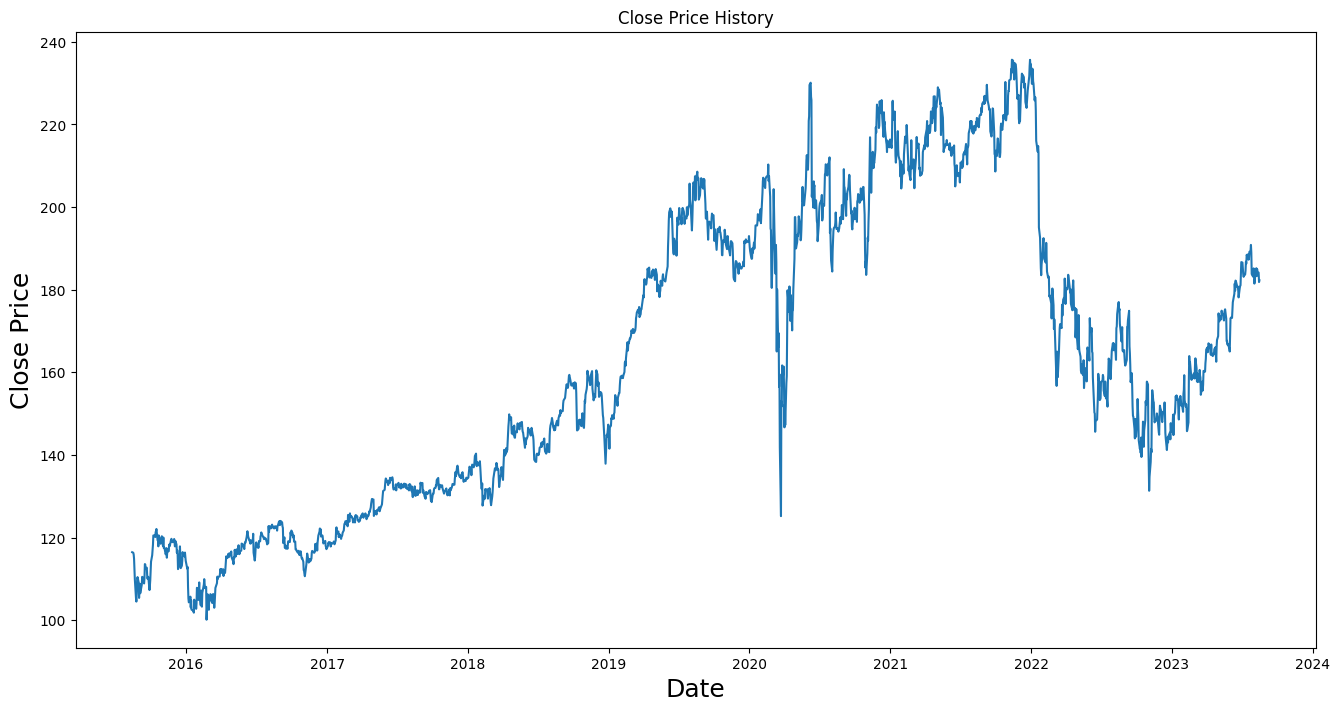

In [3]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [4]:
# Dataframe with only close column
data = df.filter(['Close'])
data = data.reset_index(drop=True)
data


,Close
0,116.480003
1,116.349998
2,115.900002
3,114.860001
4,112.620003
...,...
2010,185.000000
2011,184.360001
2012,184.160004
2013,181.860001


In [5]:
# Converting into numpy
dataset = data.values

dataset

array([[116.48000336],
       [116.34999847],
       [115.90000153],
       ...,
       [184.16000366],
       [181.86000061],
       [182.30000305]])

In [6]:
# Rows to train the model 80%
training_data_len = math.ceil(len(dataset)* .8)
training_data_len

1612

In [7]:
# Scaling the data(0-1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.12056374],
       [0.11960451],
       [0.11628423],
       ...,
       [0.61993658],
       [0.60296615],
       [0.60621268]])

In [8]:
# Creating scaled dataset

train_data = scaled_data[0:training_data_len,:]

x_train = []
y_train = []

for i in range(observation_period_num, len(train_data)):
    x_train.append(train_data[i-observation_period_num:i, 0])
    y_train.append(train_data[i,0])
    if(i<=observation_period_num):
        print(x_train)
        print(y_train)                        # y is the value we want our model to pred

[array([0.12056374, 0.11960451, 0.11628423])]
[0.10861064969589385]


In [9]:
# x_train and y_train into numpy

x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# Data shape

x_train.shape

(1609, 3)

In [11]:
# Reshaping the data since LSTM accepts 3D data so,

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1609, 3, 1)

In [12]:
# Building LSTM model

model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(256, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [13]:
# Compile the model

model.compile(optimizer= 'adam', loss='mean_squared_error')

In [14]:
# Training the model

model.fit(x_train, y_train, batch_size=1, epochs=1)

1609/1609 [==============================] - 30s 13ms/step - loss: 0.0031


In [15]:
# Create the testing dataset
test_data = scaled_data[training_data_len-observation_period_num:, :]

# Create the dataset of x_test and y_test

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(observation_period_num, len(test_data)):
    x_test.append(test_data[i-observation_period_num:i,0])

In [16]:
# Convert data into numpy array

x_test = np.array(x_test)

In [17]:
# Reshape the data

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
# Get the model price prediction values
predictions = model.predict(x_test)

# Back into normal form

predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 8ms/step


In [19]:
# Getting the root mean squared error

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

9.167085474486976

In [20]:
# Plotting the data

train = data
valid = data[training_data_len:]
valid['Predictions'] = predictions

valid

<ipython-input-20-9982aae4ea3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Close,Predictions
1612,229.869995,211.641220
1613,225.839996,210.671799
1614,226.619995,208.814011
1615,226.490005,207.734558
1616,223.279999,206.829773
...,...,...
2010,185.000000,173.149857
2011,184.360001,173.213196
2012,184.160004,173.006363
2013,181.860001,173.254517


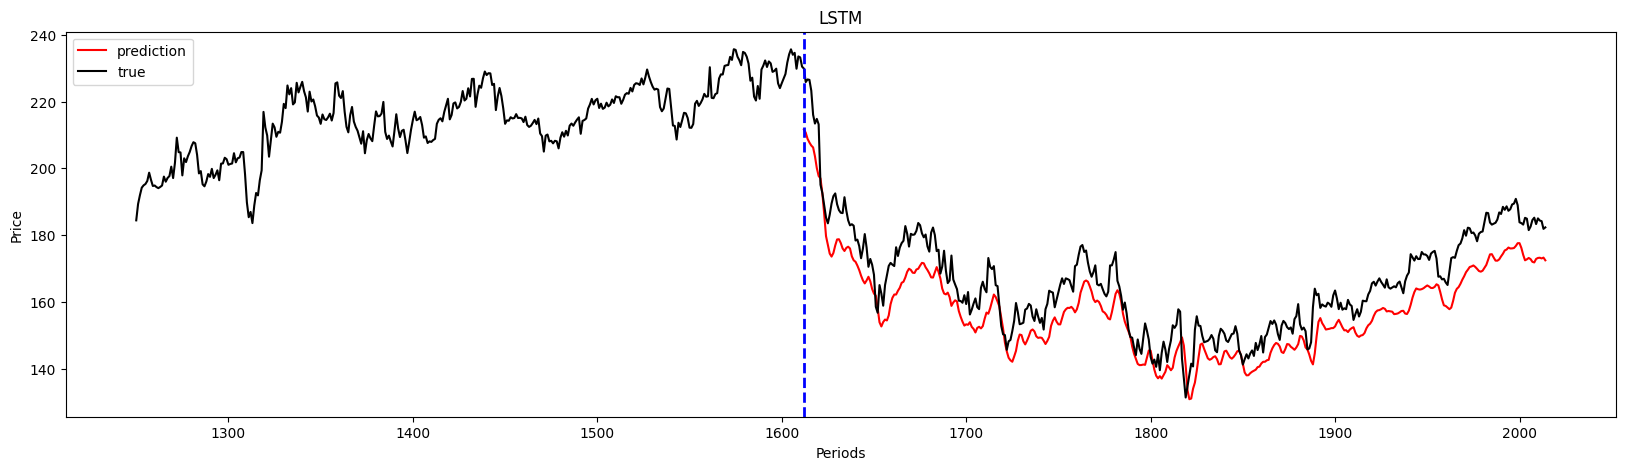

In [21]:
import matplotlib.pyplot as pyplot
fig = pyplot.figure(1, figsize=(20, 5))
fig.patch.set_facecolor('xkcd:white')
pyplot.plot(valid.iloc[:,1],color="red")
pyplot.title('LSTM')
pyplot.plot(train[1250:],color="black")
pyplot.legend(["prediction", "true"], loc="upper left")
ymin, ymax = pyplot.ylim()
pyplot.vlines(1612, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
pyplot.ylim(ymin, ymax)
pyplot.xlabel("Periods")
pyplot.ylabel("Price")
pyplot.show()
pyplot.close()